In [69]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from catboost import Pool, cv
from catboost import CatBoostRegressor

In [183]:
df = pd.read_excel("05.2022_Выручка.xlsx")
df.head()

,TimeThirty,DAT,Торговая точка,Касса,orgtype,terminal,tzone,TotalSumm
0,2022-05-01 00:00:00.000,2022-05-01,Торговая точка 0601,7683,Общепит,B,Чистая зона ВВЛ-вылет,755 448
1,2022-05-04 13:30:00.000,2022-05-04,Торговая точка 2373,3114,Общепит,B,Общедоступная зона-вылет,46 800
2,2022-05-05 18:00:00.000,2022-05-05,Торговая точка 8998,9887,Торговля,B,Чистая зона ВВЛ-вылет,160 160
3,2022-05-25 22:00:00.000,2022-05-25,Торговая точка 8313,2251,Общепит,B,Чистая зона ВВЛ-вылет,248 960
4,2022-05-10 00:30:00.000,2022-05-10,Торговая точка 8998,9887,Торговля,B,Чистая зона ВВЛ-вылет,117 600


In [184]:
pass_data = pd.read_csv("05.2022_passdata", parse_dates=[0])
pass_data

,time,num_passengers,temperature
0,2022-05-01 00:00:00,1707,10
1,2022-05-01 00:30:00,1124,10
2,2022-05-01 01:00:00,701,10
3,2022-05-01 01:30:00,297,10
4,2022-05-01 02:00:00,148,10
...,...,...,...
1483,2022-05-31 21:30:00,0,16
1484,2022-05-31 22:00:00,0,16
1485,2022-05-31 22:30:00,0,16
1486,2022-05-31 23:00:00,0,16


In [185]:
def preprocess(df: pd.DataFrame, drop_cashier=False) -> pd.DataFrame:
    data = df.copy()

    data["TotalSumm"] = data["TotalSumm"].apply(lambda x : x.replace("\xa0", ""))
    data["TotalSumm"] = data["TotalSumm"].apply(lambda x : x.replace(",", "."))
    data["TotalSumm"] = data["TotalSumm"].astype(float)

    data["Торговая точка"] = data["Торговая точка"].apply(lambda x: x.replace("Торговая точка ", ""))

    data["TimeThirty"] = pd.to_datetime(data["TimeThirty"])
    data["Касса"] = data["Касса"].astype(object)

    data["TimeThirty"] = pd.to_datetime(data["TimeThirty"])
    data["Касса"] = data["Касса"].astype(object)

    data.drop(columns=["terminal", "DAT"], inplace=True)

    data.rename(columns={
        "TimeThirty": "time", "Торговая точка": "sell_point", 
        "Касса": "cashier", "tzone": "zone", "TotalSumm": "revenue"
    }, inplace=True)

    if drop_cashier:
        data.drop(columns=["cashier"], inplace=True)

        stacked_revenues = data.groupby(["sell_point", "time"]).agg({"revenue": "sum"}).values
        data = data.groupby(["sell_point", "time"]).first().reset_index()
        data["revenue"] = stacked_revenues

    data = data.set_index(["sell_point", "time"]).reset_index()
    data = data.sort_values(by=["sell_point", "time"])

    return data

In [186]:
def draw_ts(data: pd.DataFrame, target: str) -> None:
    sellpoints = data["sell_point"].unique()
    for i in range(len(sellpoints)):
        sp_data = data[data["sell_point"] == sellpoints[i]]
        cashiers = sp_data["cashier"].unique()
        for j in range(len(cashiers)):
            spc_data = sp_data[sp_data["cashier"] == cashiers[j]].copy()
            x = spc_data["time"]
            y = spc_data[target]
            plt.figure(figsize=(20, 5))
            plt.plot(x, y)
            plt.title(f"Sellpoint {sellpoints[i]}, cashier {cashiers[j]}")

In [187]:
def make_lag(df: pd.DataFrame, target: str, num_lags: int) -> pd.DataFrame:
    data = df.copy()
    for i in range(1, num_lags + 1):
        data[f"{target}_lag{i}"] = data[target].shift(i)
    data = data.dropna().reset_index()
    data.drop(columns="index", inplace=True)
    return data

In [221]:
def get_sellpoints_data(df):
    data = df.copy()

    sellpoints_data = []
    for sp in data["sell_point"].unique():
        sellpoints_data.append(data[data["sell_point"] == sp].copy())
    
    for i, spd in enumerate(sellpoints_data):
        sellpoints_data[i] = spd.drop(columns=["sell_point", "orgtype", "zone"], inplace=True)
        sellpoints_data[i] = make_lag(spd, "revenue", 48)
    
    return sellpoints_data

In [222]:
data = preprocess(df, drop_cashier=True)
data = data.merge(pass_data, on="time", how="left")
data = data[data["sell_point"] != "8219"]
data

,sell_point,time,orgtype,zone,revenue,num_passengers,temperature
0,0601,2022-05-01 00:00:00,Общепит,Чистая зона ВВЛ-вылет,755448.0,1707,10
1,0601,2022-05-01 00:30:00,Общепит,Чистая зона ВВЛ-вылет,1298616.0,1124,10
2,0601,2022-05-01 01:00:00,Общепит,Чистая зона ВВЛ-вылет,451200.0,701,10
3,0601,2022-05-01 01:30:00,Общепит,Чистая зона ВВЛ-вылет,276000.0,297,10
4,0601,2022-05-01 02:30:00,Общепит,Чистая зона ВВЛ-вылет,68000.0,93,10
...,...,...,...,...,...,...,...
8947,8998,2022-05-31 21:30:00,Торговля,Чистая зона ВВЛ-вылет,161200.0,0,16
8948,8998,2022-05-31 22:00:00,Торговля,Чистая зона ВВЛ-вылет,179360.0,0,16
8949,8998,2022-05-31 22:30:00,Торговля,Чистая зона ВВЛ-вылет,304720.0,0,16
8950,8998,2022-05-31 23:00:00,Торговля,Чистая зона ВВЛ-вылет,550640.0,0,16


In [223]:
sellpoints_data = get_sellpoints_data(data)

In [224]:
train_data = []
for i, spd in enumerate(sellpoints_data):
    X = spd.drop(columns=["revenue"])
    y = spd["revenue"]
    train_data.append((X, y))

In [231]:
train_data[0][0].dtypes

time              datetime64[ns]
num_passengers             int64
temperature                int64
revenue_lag1             float64
revenue_lag2             float64
revenue_lag3             float64
revenue_lag4             float64
revenue_lag5             float64
revenue_lag6             float64
revenue_lag7             float64
revenue_lag8             float64
revenue_lag9             float64
revenue_lag10            float64
revenue_lag11            float64
revenue_lag12            float64
revenue_lag13            float64
revenue_lag14            float64
revenue_lag15            float64
revenue_lag16            float64
revenue_lag17            float64
revenue_lag18            float64
revenue_lag19            float64
revenue_lag20            float64
revenue_lag21            float64
revenue_lag22            float64
revenue_lag23            float64
revenue_lag24            float64
revenue_lag25            float64
revenue_lag26            float64
revenue_lag27            float64
revenue_la

In [225]:
train_data[0][0].head()

,time,num_passengers,temperature,revenue_lag1,revenue_lag2,revenue_lag3,revenue_lag4,revenue_lag5,revenue_lag6,revenue_lag7,...,revenue_lag39,revenue_lag40,revenue_lag41,revenue_lag42,revenue_lag43,revenue_lag44,revenue_lag45,revenue_lag46,revenue_lag47,revenue_lag48
0,2022-05-02 06:00:00,438,9,969992.0,806400.0,519382.4,184320.0,65600.0,195200.0,41600.0,...,2308792.8,1093464.0,349816.0,675120.0,182400.0,68000.0,276000.0,451200.0,1298616.0,755448.0
1,2022-05-02 06:30:00,424,9,1378153.6,969992.0,806400.0,519382.4,184320.0,65600.0,195200.0,...,740825.6,2308792.8,1093464.0,349816.0,675120.0,182400.0,68000.0,276000.0,451200.0,1298616.0
2,2022-05-02 07:00:00,418,9,1281487.2,1378153.6,969992.0,806400.0,519382.4,184320.0,65600.0,...,1538000.0,740825.6,2308792.8,1093464.0,349816.0,675120.0,182400.0,68000.0,276000.0,451200.0
3,2022-05-02 07:30:00,418,9,459692.8,1281487.2,1378153.6,969992.0,806400.0,519382.4,184320.0,...,507625.6,1538000.0,740825.6,2308792.8,1093464.0,349816.0,675120.0,182400.0,68000.0,276000.0
4,2022-05-02 08:00:00,417,14,959492.8,459692.8,1281487.2,1378153.6,969992.0,806400.0,519382.4,...,1942877.6,507625.6,1538000.0,740825.6,2308792.8,1093464.0,349816.0,675120.0,182400.0,68000.0


In [95]:
models = []
num_iters = [150, 75, 150, 150, 60, 150, 100]
for i, (X, y) in enumerate(train_data):
    params = {"iterations": num_iters[i],
              "depth": 6,
              "loss_function": "RMSE",
              'eval_metric': 'R2',
              'learning_rate': 0.03,
              'custom_metric' : ['MAE'],
              "verbose": False,
            "use_best_model": True}

    cv_dataset = Pool(data=X,
                      label=y)

    scores_base = cv(cv_dataset,
                params,
                # stratified=True,
                return_models=True,
                fold_count=5,
                shuffle="True",
                plot="True")
    
    models.append(scores_base[1][0])

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.2763777704
bestIteration = 147

Training on fold [1/5]

bestTest = 0.2923533487
bestIteration = 148

Training on fold [2/5]

bestTest = 0.2894206361
bestIteration = 149

Training on fold [3/5]

bestTest = 0.332495501
bestIteration = 149

Training on fold [4/5]

bestTest = 0.2997298993
bestIteration = 149



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.01691704824
bestIteration = 74

Training on fold [1/5]

bestTest = 0.0204845916
bestIteration = 74

Training on fold [2/5]

bestTest = 0.03050528502
bestIteration = 74

Training on fold [3/5]

bestTest = -0.03053693488
bestIteration = 74

Training on fold [4/5]

bestTest = 0.01508604568
bestIteration = 74



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.3096180869
bestIteration = 144

Training on fold [1/5]

bestTest = 0.3116996094
bestIteration = 148

Training on fold [2/5]

bestTest = 0.3765810163
bestIteration = 149

Training on fold [3/5]

bestTest = 0.3489012383
bestIteration = 149

Training on fold [4/5]

bestTest = 0.3470609128
bestIteration = 149



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.5672983141
bestIteration = 149

Training on fold [1/5]

bestTest = 0.5940497278
bestIteration = 148

Training on fold [2/5]

bestTest = 0.5343726245
bestIteration = 149

Training on fold [3/5]

bestTest = 0.5534153939
bestIteration = 148

Training on fold [4/5]

bestTest = 0.489462041
bestIteration = 135



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = -0.01992473656
bestIteration = 59

Training on fold [1/5]

bestTest = 0.02011218581
bestIteration = 59

Training on fold [2/5]

bestTest = 0.02812675084
bestIteration = 59

Training on fold [3/5]

bestTest = -0.003373685749
bestIteration = 59

Training on fold [4/5]

bestTest = -0.07387740464
bestIteration = 59



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.5798646905
bestIteration = 149

Training on fold [1/5]

bestTest = 0.5877219928
bestIteration = 147

Training on fold [2/5]

bestTest = 0.530745283
bestIteration = 149

Training on fold [3/5]

bestTest = 0.5571999527
bestIteration = 148

Training on fold [4/5]

bestTest = 0.4932468503
bestIteration = 149



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.1968231817
bestIteration = 98

Training on fold [1/5]

bestTest = 0.1258159373
bestIteration = 99

Training on fold [2/5]

bestTest = 0.2293138622
bestIteration = 99

Training on fold [3/5]

bestTest = 0.1600130818
bestIteration = 99

Training on fold [4/5]

bestTest = 0.1604556961
bestIteration = 99



---

In [171]:
df2 = pd.read_excel("06.2022_Выручка.xlsx")
df2.head()

,TimeThirty,DAT,Торговая точка,Касса,orgtype,terminal,tzone,TotalSumm
0,2022-06-05 00:00:00.000,2022-06-05,Торговая точка 5648,3601,Общепит,B,Чистая зона ВВЛ-прилет,298 560
1,2022-06-17 03:00:00.000,2022-06-17,Торговая точка 8313,538,Общепит,B,Чистая зона ВВЛ-вылет,103 680
2,2022-06-29 15:00:00.000,2022-06-29,Торговая точка 2968,9033,Общепит,B,Чистая зона ВВЛ-вылет,5 796 800
3,2022-06-29 10:00:00.000,2022-06-29,Торговая точка 2373,3114,Общепит,B,Общедоступная зона-вылет,114 800
4,2022-06-29 14:30:00.000,2022-06-29,Торговая точка 5648,3601,Общепит,B,Чистая зона ВВЛ-прилет,98 720


In [172]:
pass_data2 = pd.read_csv("06.2022_passdata", parse_dates=[0])
pass_data2

,time,num_passengers,temperature
0,2022-06-01 00:00:00,1361,19
1,2022-06-01 00:30:00,780,19
2,2022-06-01 01:00:00,462,19
3,2022-06-01 01:30:00,264,19
4,2022-06-01 02:00:00,94,19
...,...,...,...
1435,2022-06-30 21:30:00,0,23
1436,2022-06-30 22:00:00,0,23
1437,2022-06-30 22:30:00,0,23
1438,2022-06-30 23:00:00,0,23


In [182]:
data2 = preprocess(df2, drop_cashier=True)
data2 = data2.merge(pass_data2, on="time", how="left")
data2 = data2[data2["sell_point"] != "8219"]
data2

,sell_point,time,orgtype,zone,revenue,num_passengers,temperature
0,0601,2022-06-01 00:00:00,Общепит,Чистая зона ВВЛ-вылет,256000.0,1361,19
1,0601,2022-06-01 00:30:00,Общепит,Чистая зона ВВЛ-вылет,116800.0,780,19
2,0601,2022-06-01 01:00:00,Общепит,Чистая зона ВВЛ-вылет,200360.0,462,19
3,0601,2022-06-01 02:00:00,Общепит,Чистая зона ВВЛ-вылет,124000.0,94,19
4,0601,2022-06-01 03:00:00,Общепит,Чистая зона ВВЛ-вылет,131200.0,27,19
...,...,...,...,...,...,...,...
8862,8998,2022-06-30 21:30:00,Торговля,Чистая зона ВВЛ-вылет,991440.0,0,23
8863,8998,2022-06-30 22:00:00,Торговля,Чистая зона ВВЛ-вылет,521680.0,0,23
8864,8998,2022-06-30 22:30:00,Торговля,Чистая зона ВВЛ-вылет,458000.0,0,23
8865,8998,2022-06-30 23:00:00,Торговля,Чистая зона ВВЛ-вылет,411600.0,0,23


In [226]:
sellpoints_data = get_sellpoints_data(pd.concat([data, data2]))

In [227]:
test_data = []
for i, spd in enumerate(sellpoints_data):
    X = spd[spd["time"].dt.month == 6].drop(columns=["revenue"])
    test_data.append(X)

In [ ]:
for i, X in enumerate(test_data):
    for j in range(len(X)):
        prediction = models[i].predict(X.iloc[j, :])
        X.loc[j, "revenue"] = prediction
        if (j != len(X) - 1):
            X.loc[j + 1, "revenue_lag1"] = prediction
            X.loc[j + 1, [f"revenue_lag{k}" for k in range(2, j + 2)]] = X.loc[j, [f"revenue_lag{k}" for k in range(1, j + 1)]]

In [233]:
import phik

interval columns not set, guessing: ['revenue', 'temperature', 'num_passengers']


<AxesSubplot: >

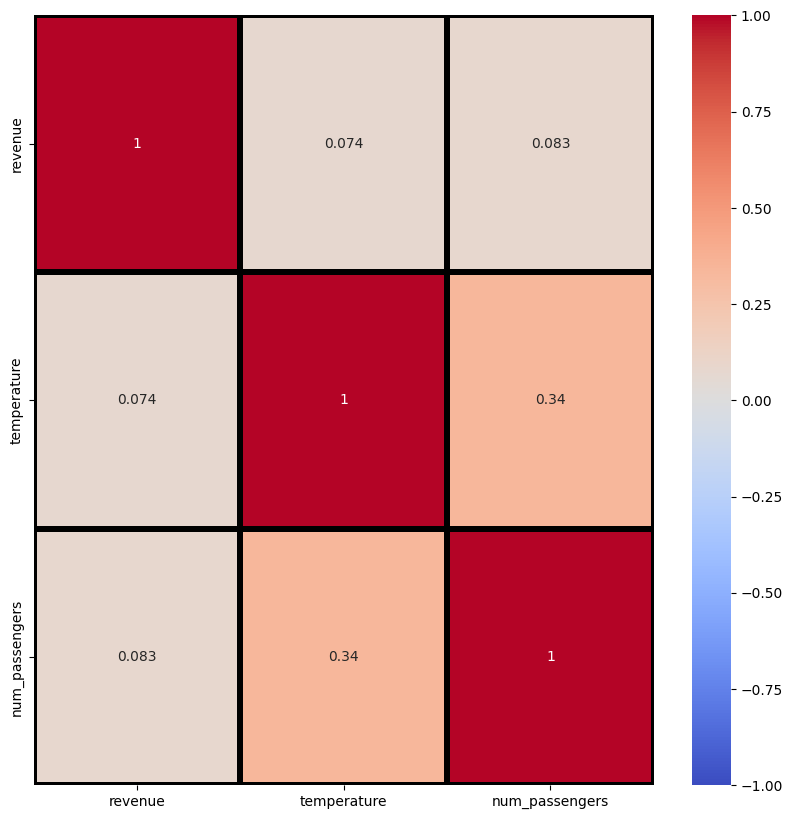

In [234]:
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(data[["revenue", "temperature", "num_passengers"]].phik_matrix(),annot = True, vmin=-1, vmax=1, 
            center= 0, cmap= 'coolwarm', linewidths=3, linecolor='black', ax=ax)